# Background

The data was collected on 28 August 2019 according to the [website](http://insideairbnb.com/get-the-data.html). There is 7907 sample, but there is some missing data on some feature/variable. And the original context is [here](https://www.kaggle.com/jojoker/singapore-airbnb)

Can you find out how many feature that affected the price? by the way do you have an idea what is reviews_per_month means?

# Prepare Packages 

In [271]:
import numpy as np
import pandas as pd
import datetime
from dateutil import relativedelta 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import folium
from folium.plugins import HeatMap
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

# Exploratory Data Analysis

## Clean data

### Drop unused columns and create new variables

In [239]:
df = pd.read_csv('listings.csv')
df.head()

id                                 name  host_id  host_name  \
0  49091    COZICOMFORT LONG TERM STAY ROOM 2   266763  Francesca   
1  50646      Pleasant Room along Bukit Timah   227796    Sujatha   
2  56334                          COZICOMFORT   266763  Francesca   
3  71609  Ensuite Room (Room 1 & 2) near EXPO   367042    Belinda   
4  71896      B&B  Room 1 near Airport & EXPO   367042    Belinda   

  neighbourhood_group neighbourhood  latitude  longitude     room_type  price  \
0        North Region     Woodlands   1.44255  103.79580  Private room     83   
1      Central Region   Bukit Timah   1.33235  103.78521  Private room     81   
2        North Region     Woodlands   1.44246  103.79667  Private room     69   
3         East Region      Tampines   1.34541  103.95712  Private room    206   
4         East Region      Tampines   1.34567  103.95963  Private room     94   

   minimum_nights  number_of_reviews last_review  reviews_per_month  \
0             180                  1  2013-10-21               0.01   
1              90                 18  2014-12-26               0.28   
2               6                 20  2015-10-01               0.20   
3               1                 14  2019-08-11               0.15   
4               1                 22  2019-07-28               0.22   

   calculated_host_listings_count  availability_365  
0                               2               365  
1                               1               365  
2                               2               365  
3                               9               353  
4                               9               355

In [240]:
print('The dataset has %s records and %s columns' %(len(df), len(df.columns)))

The dataset has 7907 records and 16 columns


In [241]:
df.isnull().sum()

id                                   0
name                                 2
host_id                              0
host_name                            0
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       2758
reviews_per_month                 2758
calculated_host_listings_count       0
availability_365                     0
dtype: int64

Create sub-variables from last_review

In [242]:
df.last_review = pd.to_datetime(df.last_review)
df.collect_date = datetime.datetime(2019, 8, 28)
df['day_last_review'] = (df.collect_date - df.last_review)/np.timedelta64(1, 'D')
df['month_last_review'] = (df.collect_date - df.last_review)/np.timedelta64(1, 'M')
df['year_last_review'] = (df.collect_date - df.last_review)/np.timedelta64(1, 'Y')
df = df.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1)
df.head()

neighbourhood_group neighbourhood  latitude  longitude     room_type  price  \
0        North Region     Woodlands   1.44255  103.79580  Private room     83   
1      Central Region   Bukit Timah   1.33235  103.78521  Private room     81   
2        North Region     Woodlands   1.44246  103.79667  Private room     69   
3         East Region      Tampines   1.34541  103.95712  Private room    206   
4         East Region      Tampines   1.34567  103.95963  Private room     94   

   minimum_nights  number_of_reviews  reviews_per_month  \
0             180                  1               0.01   
1              90                 18               0.28   
2               6                 20               0.20   
3               1                 14               0.15   
4               1                 22               0.22   

   calculated_host_listings_count  availability_365  day_last_review  \
0                               2               365           2137.0   
1                               1               365           1706.0   
2                               2               365           1427.0   
3                               9               353             17.0   
4                               9               355             31.0   

   month_last_review  year_last_review  
0          70.210887          5.850907  
1          56.050432          4.670869  
2          46.883920          3.906993  
3           0.558533          0.046544  
4           1.018501          0.084875

### Fill null values

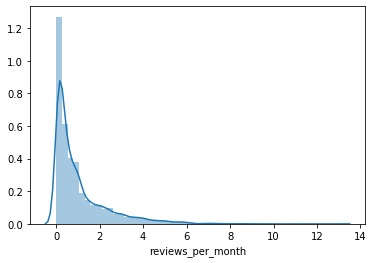

In [247]:
sns.distplot(df['reviews_per_month'].dropna(how='any', axis=0))

In [248]:
s = df.reviews_per_month.value_counts(normalize=True)
missing = df['reviews_per_month'].isnull()
df.loc[missing,'reviews_per_month'] = np.random.choice(s.index, size=len(df[missing]),p=s.values)

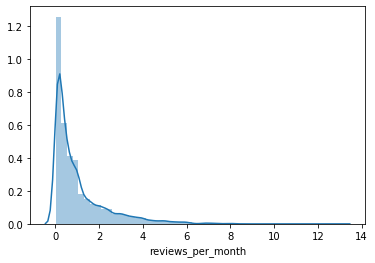

In [249]:
sns.distplot(df['reviews_per_month'].dropna(how='any', axis=0))

Fill null values based on the distribution could be a better way

In [244]:
s1 = df.day_last_review.value_counts(normalize=True)
missing1 = df['day_last_review'].isnull()
df.loc[missing1,'day_last_review'] = np.random.choice(s1.index, size=len(df[missing1]),p=s1.values)

s2 = df.month_last_review.value_counts(normalize=True)
missing2 = df['month_last_review'].isnull()
df.loc[missing2,'month_last_review'] = np.random.choice(s2.index, size=len(df[missing2]),p=s2.values)

s3 = df.year_last_review.value_counts(normalize=True)
missing3 = df['year_last_review'].isnull()
df.loc[missing3,'year_last_review'] = np.random.choice(s3.index, size=len(df[missing3]),p=s3.values)

In [250]:
df.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
day_last_review                   0
month_last_review                 0
year_last_review                  0
dtype: int64

## Overview of the dataset

### Neighbourhood group and room type

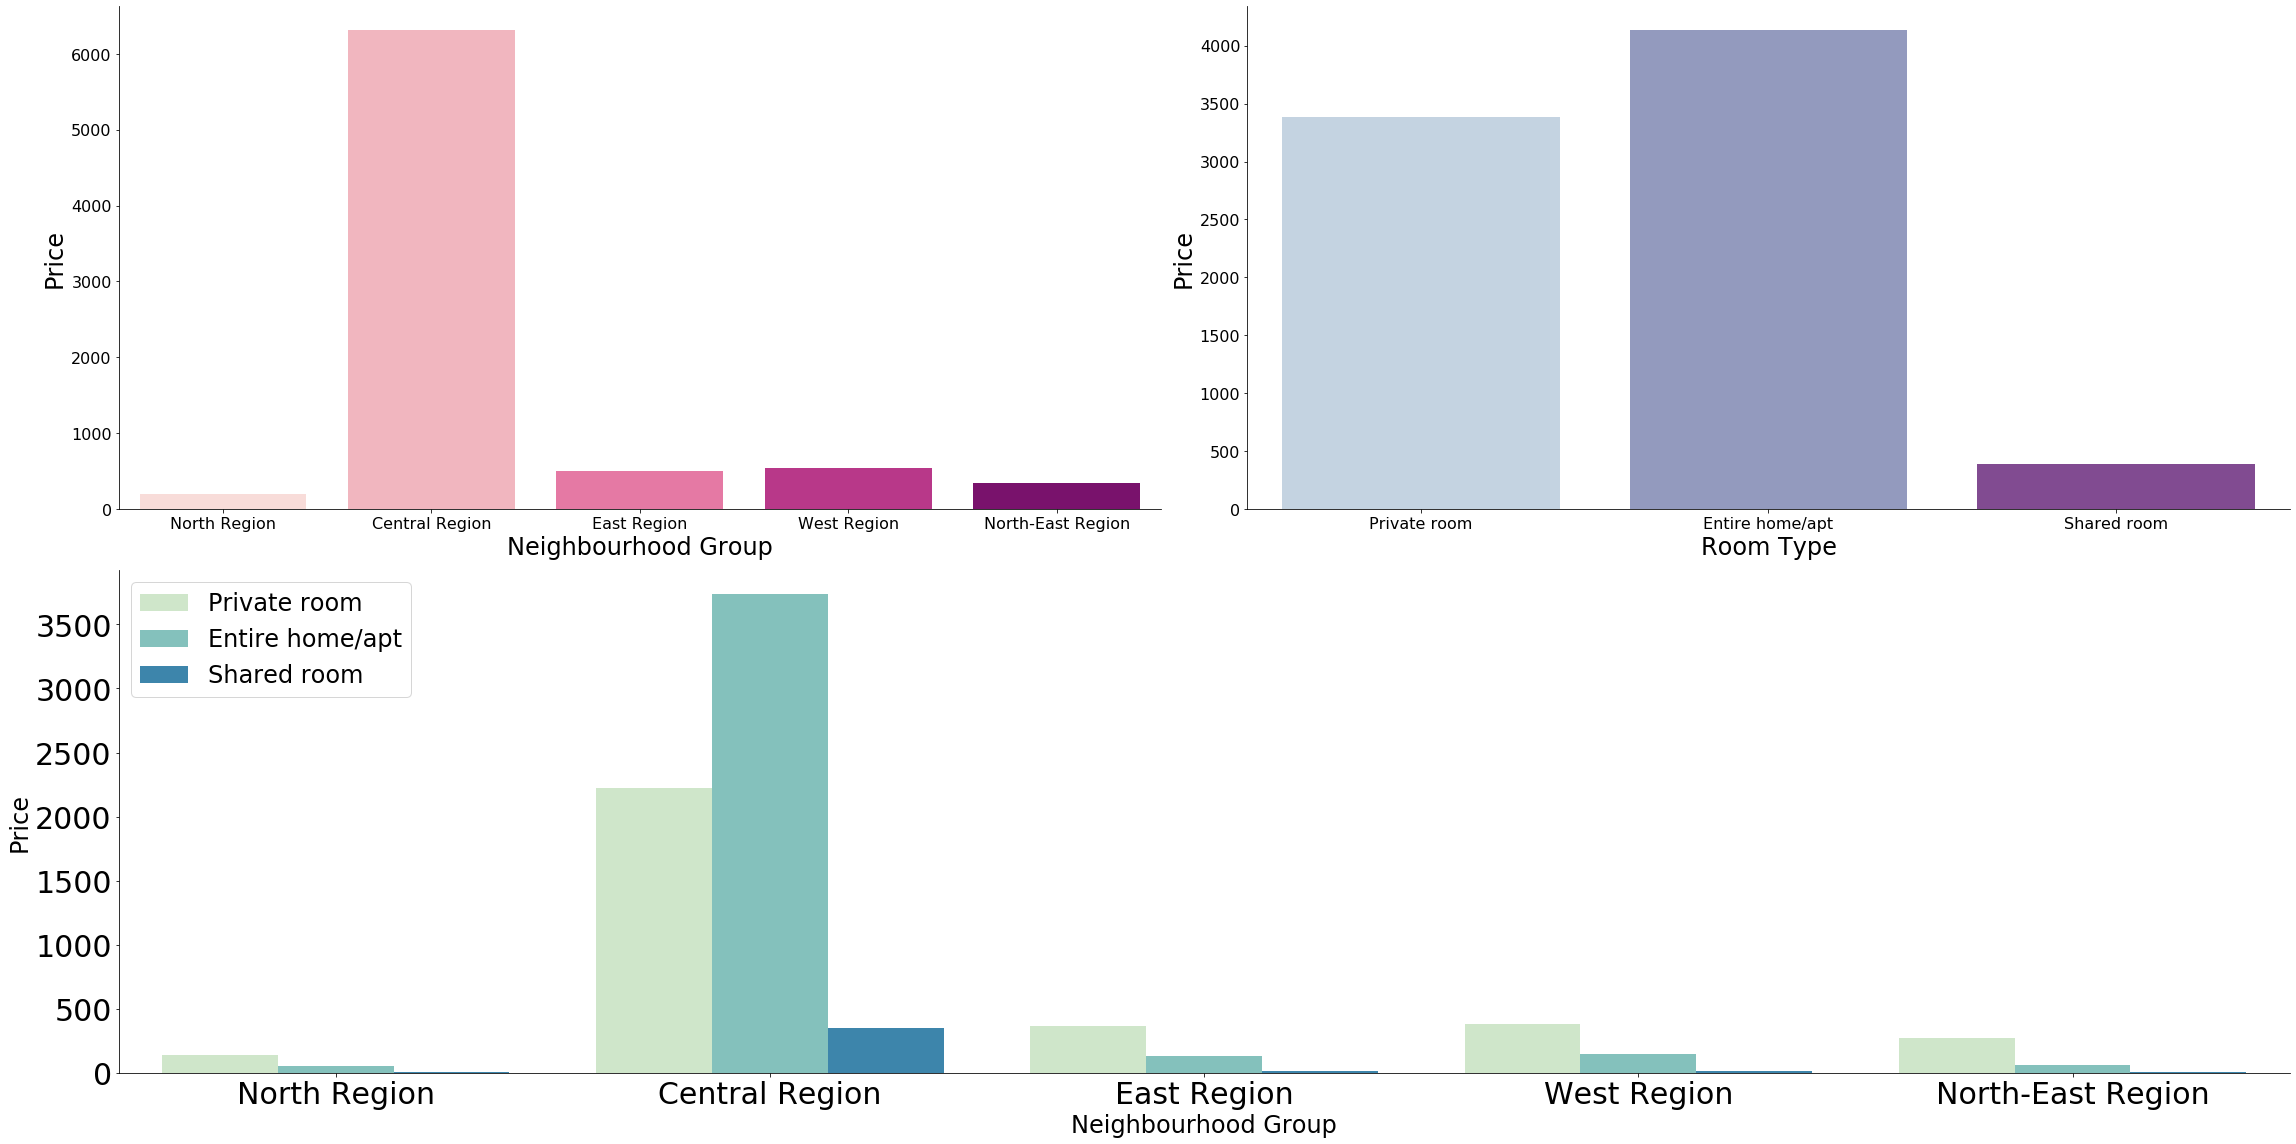

In [224]:
fig = plt.figure(figsize=(32, 16))
gs = gridspec.GridSpec(2, 2)

ax0 = plt.subplot(gs[0,0])
sns.countplot(x='neighbourhood_group', data=df, ax=ax0, palette='RdPu')
ax0.set_xlabel('Neighbourhood Group', fontsize=24)
ax0.set_ylabel('Price', fontsize = 24)
ax0.tick_params(axis='both', labelsize=16)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)


ax1 = plt.subplot(gs[0,1])
sns.countplot(x='room_type', data=df, ax=ax1, palette='BuPu')
ax1.set_xlabel('Room Type', fontsize=24)
ax1.set_ylabel('Price', fontsize = 24)
ax1.tick_params(axis='both', labelsize=16)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = plt.subplot(gs[1, :])
sns.countplot(x='neighbourhood_group', hue='room_type', data=df, ax=ax2, palette='GnBu')
ax2.set_xlabel('Neighbourhood Group', fontsize=24)
ax2.set_ylabel('Price', fontsize = 24)
ax2.tick_params(axis='both', labelsize=30)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend(loc='upper left', fontsize=24)

plt.tight_layout()

### Maps

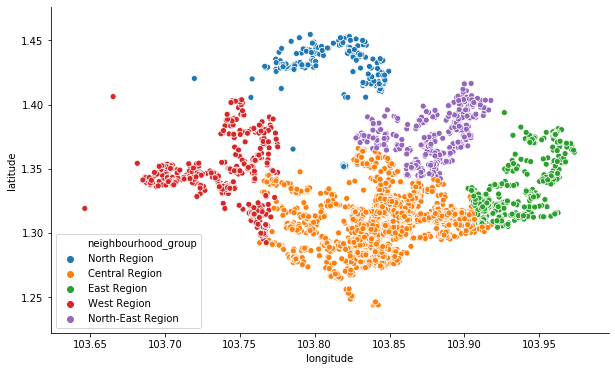

In [225]:
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
sns.scatterplot(df.longitude,df.latitude,hue=df.neighbourhood_group, ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ioff()

In [226]:
df.latitude.max()

1.45459

In [227]:
m=folium.Map([1.44255,103.79580],zoom_start=11)
HeatMap(df[['latitude','longitude']].dropna(),radius=8,gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(m)
display(m)

## Relationship between features and price

In [228]:
# Neighbourhood_group
# df_ng = df.groupby(['neighbourhood_group']).mean()['price'].to_frame().reset_index()
# Room_type
# df_rt = df.groupby(['room_type']).mean()['price'].to_frame().reset_index()

### Price vs neigbourhood & room type

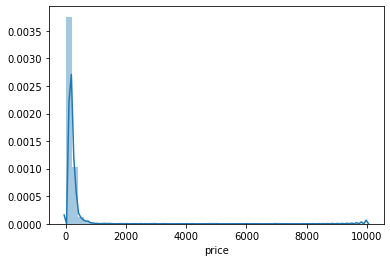

In [229]:
sns.distplot(df["price"])

Some prices are too large and will affect the final result. So we filter the data by 'price <= 250'

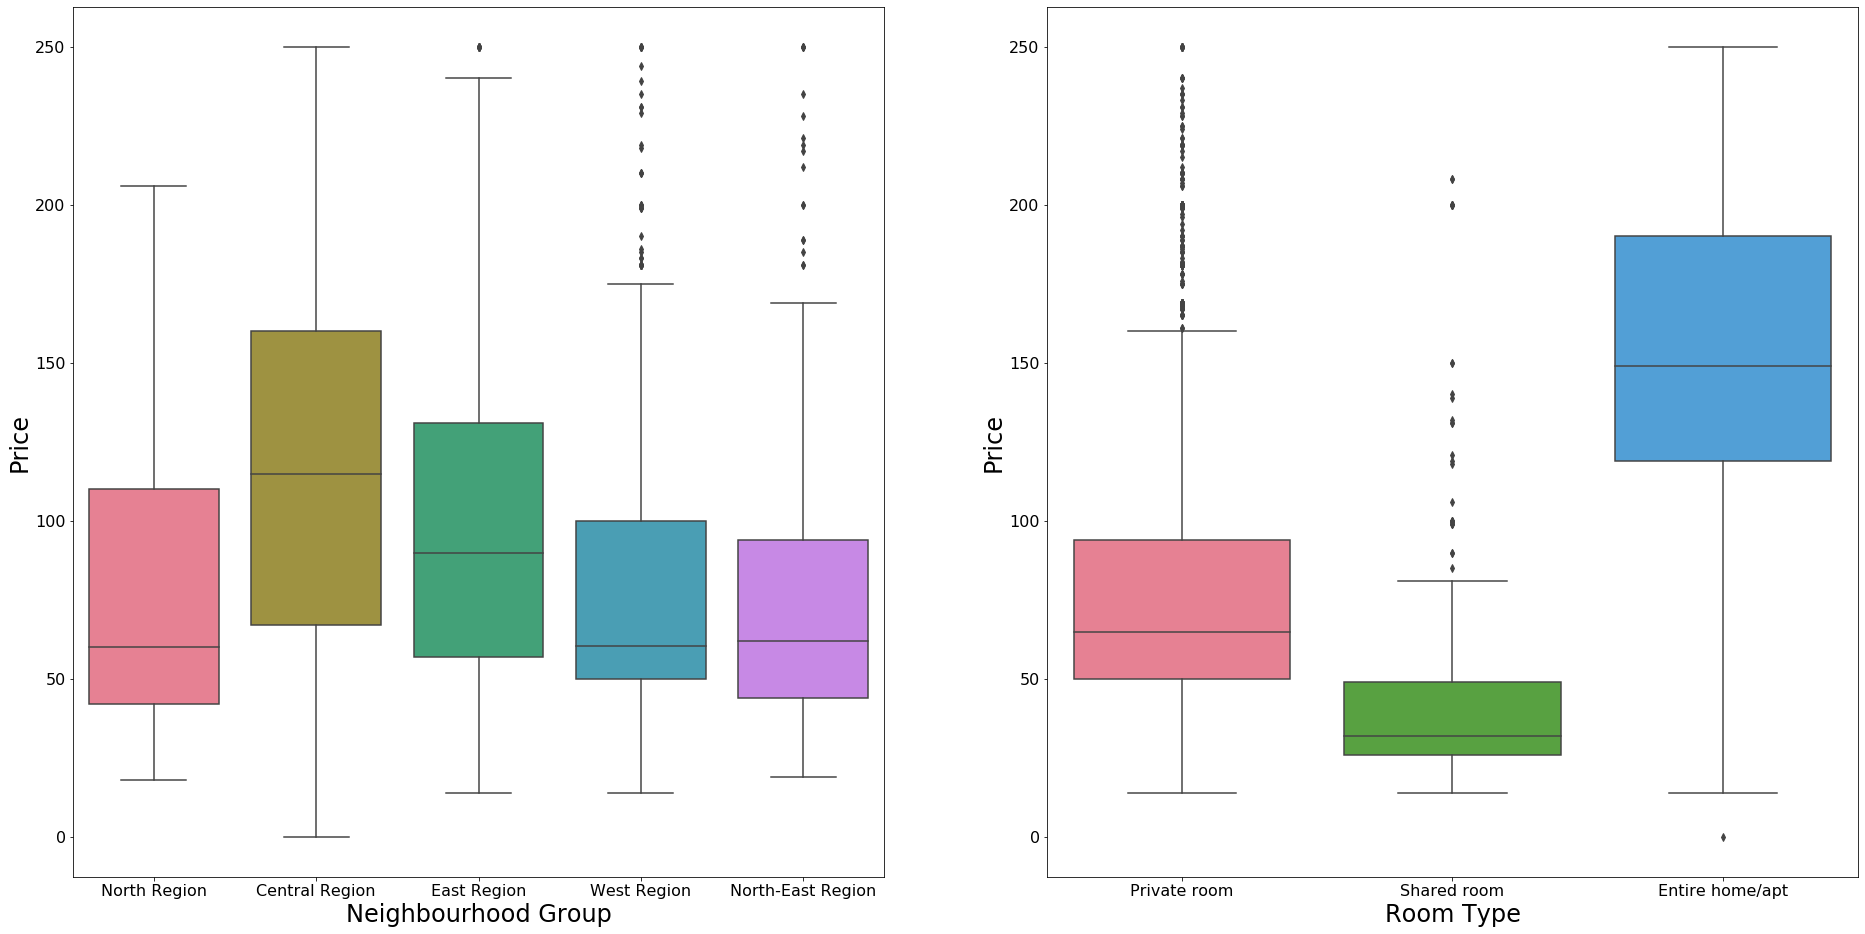

In [230]:
fig, ax = plt.subplots(1, 2, figsize=(32, 16))

sns.boxplot(y='price', x='neighbourhood_group', data=df[df.price <= 250], ax=ax[0], palette='husl')
ax[0].set_xlabel('Neighbourhood Group', fontsize=24)
ax[0].set_ylabel('Price', fontsize = 24)
ax[0].tick_params(axis='both', labelsize=16)

sns.boxplot(y='price', x='room_type', data=df[df.price <= 250], ax=ax[1], palette='husl')
ax[1].set_xlabel('Room Type', fontsize=24)
ax[1].set_ylabel('Price', fontsize=24)
ax[1].tick_params(axis='both', labelsize=16)

### Price vs minimum nights & number of reviews

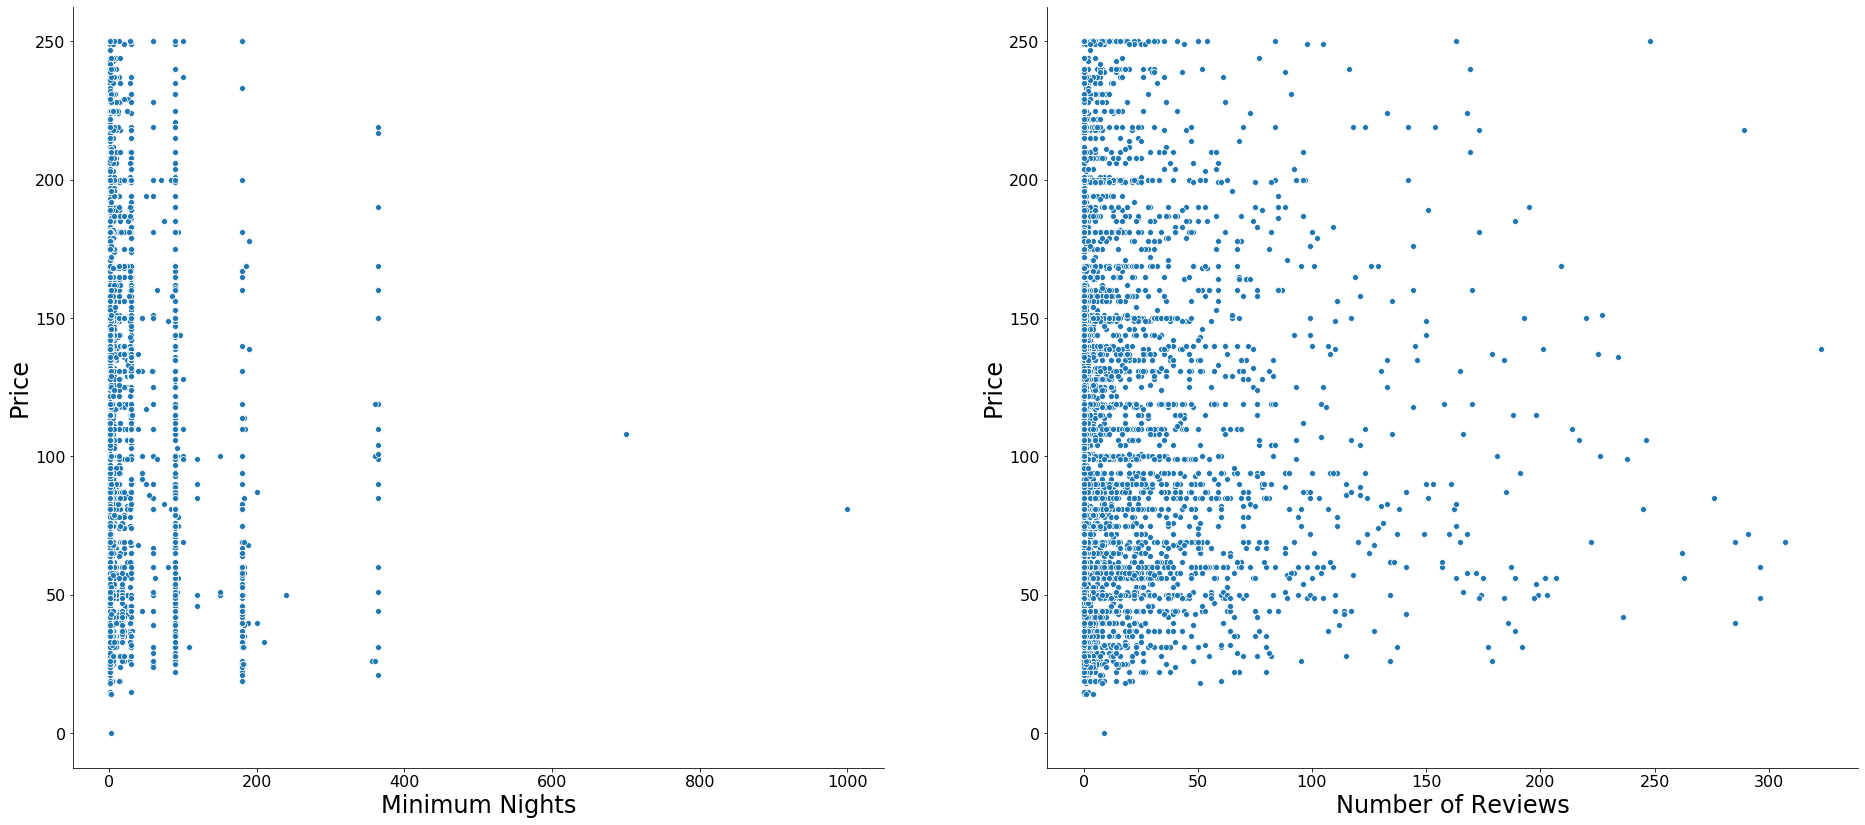

In [231]:
fig, ax = plt.subplots(1, 2, figsize=(32, 14))

sns.scatterplot(y='price', x='minimum_nights', data=df[df.price<=250], ax=ax[0], markers=True)
ax[0].set_xlabel('Minimum Nights', fontsize=24)
ax[0].set_ylabel('Price', fontsize=24)
ax[0].tick_params(axis='both', labelsize=16)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

sns.scatterplot(y='price', x='number_of_reviews', data=df[df.price<=250], ax=ax[1], markers=True)
ax[1].set_xlabel('Number of Reviews', fontsize=24)
ax[1].set_ylabel('Price', fontsize=24)
ax[1].tick_params(axis='both', labelsize=16)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

### Price vs reviews per month & calculated host listings count

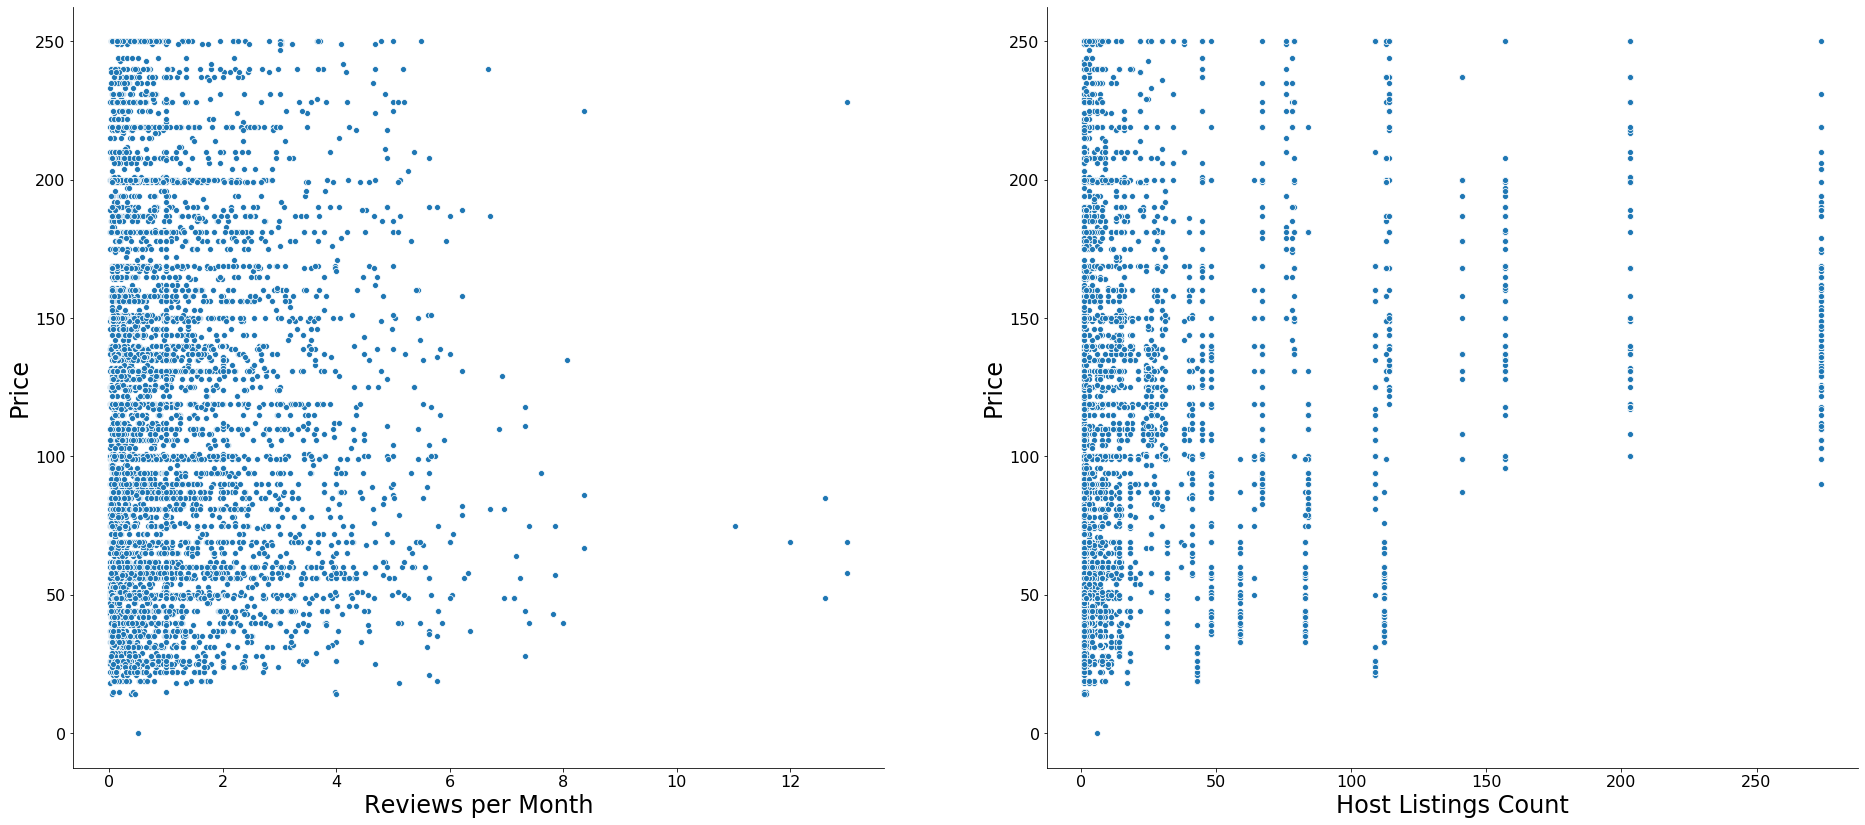

In [232]:
fig, ax = plt.subplots(1, 2, figsize=(32, 14))

sns.scatterplot(y='price', x='reviews_per_month', data=df[df.price<=250], ax=ax[0], markers=True)
ax[0].set_xlabel('Reviews per Month', fontsize=24)
ax[0].set_ylabel('Price', fontsize=24)
ax[0].tick_params(axis='both', labelsize=16)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

sns.scatterplot(y='price', x='calculated_host_listings_count', data=df[df.price<=250], ax=ax[1], markers=True)
ax[1].set_xlabel('Host Listings Count', fontsize=24)
ax[1].set_ylabel('Price', fontsize=24)
ax[1].tick_params(axis='both', labelsize=16)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

### Price vs last review & availability of 265

In [256]:
df.head()

neighbourhood_group neighbourhood  latitude  longitude     room_type  price  \
0        North Region     Woodlands   1.44255  103.79580  Private room     83   
1      Central Region   Bukit Timah   1.33235  103.78521  Private room     81   
2        North Region     Woodlands   1.44246  103.79667  Private room     69   
3         East Region      Tampines   1.34541  103.95712  Private room    206   
4         East Region      Tampines   1.34567  103.95963  Private room     94   

   minimum_nights  number_of_reviews  reviews_per_month  \
0             180                  1               0.01   
1              90                 18               0.28   
2               6                 20               0.20   
3               1                 14               0.15   
4               1                 22               0.22   

   calculated_host_listings_count  availability_365  day_last_review  \
0                               2               365           2137.0   
1                               1               365           1706.0   
2                               2               365           1427.0   
3                               9               353             17.0   
4                               9               355             31.0   

   month_last_review  year_last_review  
0          70.210887          5.850907  
1          56.050432          4.670869  
2          46.883920          3.906993  
3           0.558533          0.046544  
4           1.018501          0.084875

In [257]:
type(df.day_last_review)

pandas.core.series.Series

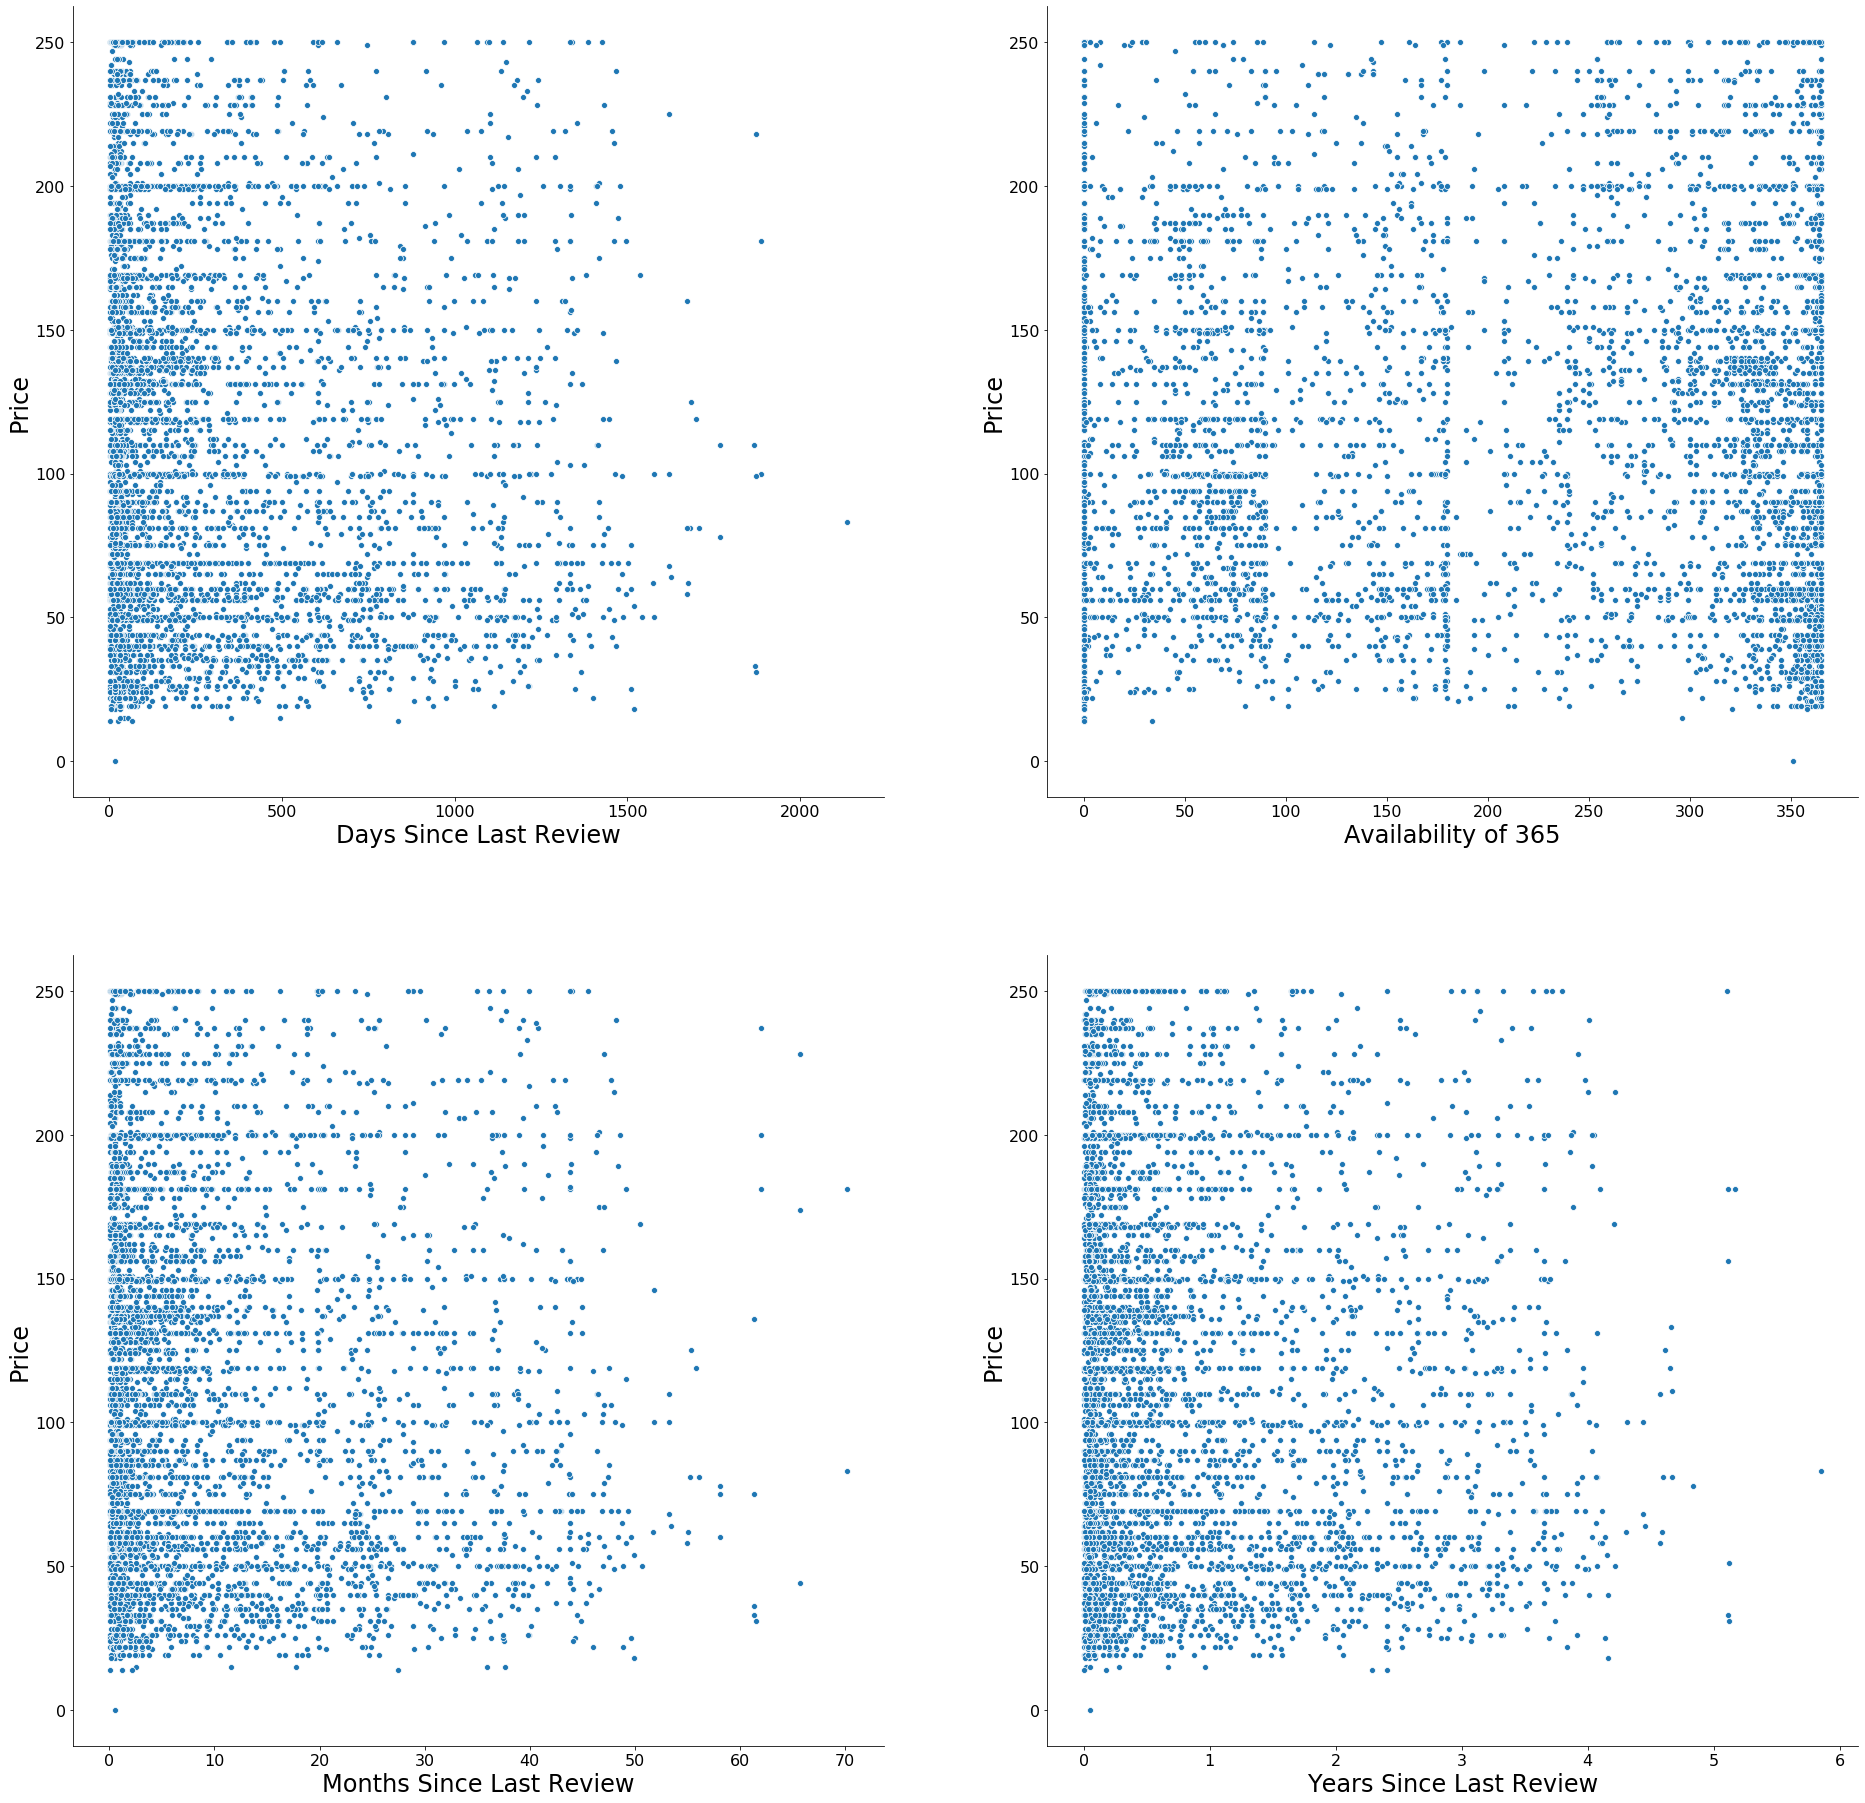

In [259]:
fig, ax = plt.subplots(2, 2, figsize=(32, 32))
ax = ax.flatten()

sns.scatterplot(y='price', x='day_last_review', data=df[df.price<=250], ax=ax[0], markers=True)
ax[0].set_xlabel('Days Since Last Review', fontsize=24)
ax[0].set_ylabel('Price', fontsize=24)
ax[0].tick_params(axis='both', labelsize=16)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

sns.scatterplot(y='price', x='availability_365', data=df[df.price<=250], ax=ax[1], markers=True)
ax[1].set_xlabel('Availability of 365', fontsize=24)
ax[1].set_ylabel('Price', fontsize=24)
ax[1].tick_params(axis='both', labelsize=16)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

sns.scatterplot(y='price', x='month_last_review', data=df[df.price<=250], ax=ax[2], markers=True)
ax[2].set_xlabel('Months Since Last Review', fontsize=24)
ax[2].set_ylabel('Price', fontsize=24)
ax[2].tick_params(axis='both', labelsize=16)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)

sns.scatterplot(y='price', x='year_last_review', data=df[df.price<=250], ax=ax[3], markers=True)
ax[3].set_xlabel('Years Since Last Review', fontsize=24)
ax[3].set_ylabel('Price', fontsize=24)
ax[3].tick_params(axis='both', labelsize=16)
ax[3].spines['top'].set_visible(False)
ax[3].spines['right'].set_visible(False)

# Machine Learning for Predicting Price

## Data preprocessing - categorical to numerical

In [260]:
le = LabelEncoder()

le.fit(df['neighbourhood_group'])
df['neighbourhood_group']=le.transform(df['neighbourhood_group'])

le.fit(df['neighbourhood'])
df['neighbourhood'] = le.transform(df['neighbourhood'])

le.fit(df['room_type'])
df['room_type'] = le.transform(df['room_type'])

df.head()

neighbourhood_group  neighbourhood  latitude  longitude  room_type  price  \
0                    2             41   1.44255  103.79580          1     83   
1                    0              6   1.33235  103.78521          1     81   
2                    2             41   1.44246  103.79667          1     69   
3                    1             36   1.34541  103.95712          1    206   
4                    1             36   1.34567  103.95963          1     94   

   minimum_nights  number_of_reviews  reviews_per_month  \
0             180                  1               0.01   
1              90                 18               0.28   
2               6                 20               0.20   
3               1                 14               0.15   
4               1                 22               0.22   

   calculated_host_listings_count  availability_365  day_last_review  \
0                               2               365           2137.0   
1                               1               365           1706.0   
2                               2               365           1427.0   
3                               9               353             17.0   
4                               9               355             31.0   

   month_last_review  year_last_review  
0          70.210887          5.850907  
1          56.050432          4.670869  
2          46.883920          3.906993  
3           0.558533          0.046544  
4           1.018501          0.084875

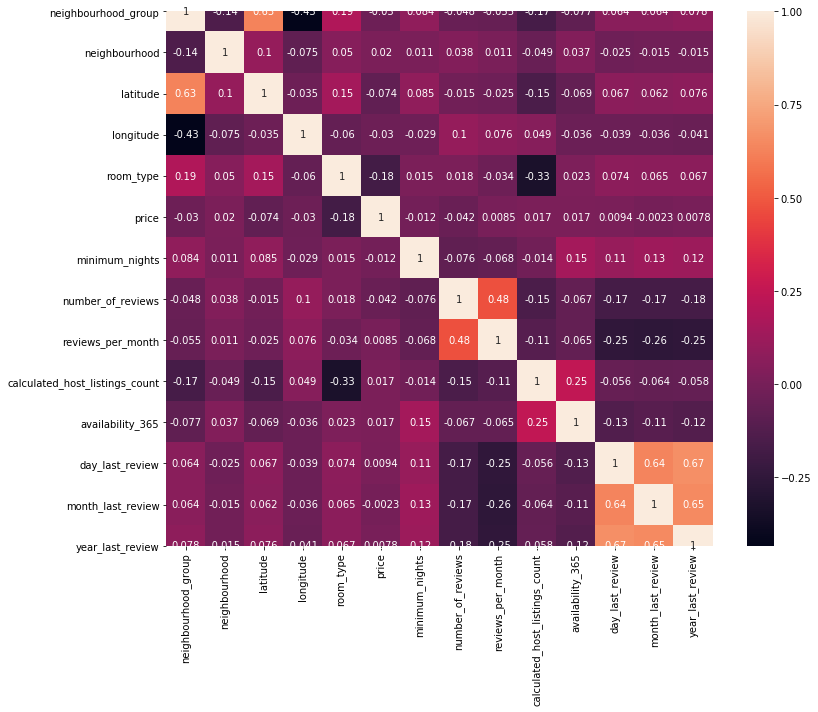

In [261]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True)
plt.tight_layout()

## Train the model

In [263]:
lm = LinearRegression()

X = df[['neighbourhood_group','neighbourhood','latitude','longitude','room_type','minimum_nights','number_of_reviews','calculated_host_listings_count','availability_365',
        'day_last_review', 'month_last_review', 'year_last_review']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [264]:
predicts = lm.predict(X_test)
error_airbnb = pd.DataFrame({
        'Actual Values': np.array(y_test).flatten(),
        'Predicted Values': predicts.flatten()})
error_airbnb.head()

Actual Values  Predicted Values
0            124        124.101827
1             62        110.966811
2            140        173.638914
3             81         25.248528
4            156        229.069909

In [272]:
title=['Pred vs Actual']
fig = go.Figure(data=[
    go.Bar(name='Predicted', x=error_airbnb.index, y=error_airbnb['Predicted Values']),
    go.Bar(name='Actual', x=error_airbnb.index, y=error_airbnb['Actual Values'])
])

fig.update_layout(barmode='group')
fig.show()